In [1]:
import pathlib
import rasterio
import numpy as np
import pandas as pd
import torch
from PIL import Image
# Written Utils Functions
from Utils.utils import build_embedding_model, compute_image_embeddings
from Utils.utils import compute_tabular_features, combine_features
# Writtent Model Functions
from Utils.computation import compute_pca_components
from Utils.computation import estimate_treatment_effect_tabular 
from Utils.computation import estimate_treatment_effect_with_embeddings
from Utils.computation import evaluate_ite, get_train_test_indices

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [30]:
# Collect file paths
DATA_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data')
SYNTH_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/Synthetic')

folders = {
    'wet': SYNTH_DIR / 'Treatment',
    'dem': DATA_DIR / 'DEM',
    'cap': DATA_DIR / 'CAPITAL_1996',
    'outcome_pre': SYNTH_DIR / 'Outcome',
    'outcome_post': SYNTH_DIR / 'Outcome_post',
    'theta': SYNTH_DIR / 'Theta'
}


scene_ids = [str(i) for i in range(1, 3566)]

In [31]:
# Tabular features
tab_df = compute_tabular_features(folders, scene_ids)
tab_df.head()

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.


Saved features to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/features.csv


,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,theta_mean,theta_std
0,1,0.768158,0.422009,64.378952,22.386531,0.0,0.0,0.095600,0.082439,0.592143,0.074387,0.522187,0.006542
1,2,0.905380,0.292689,94.023680,23.789066,0.0,0.0,0.085011,0.094904,0.687272,0.060696,0.514523,0.004503
2,3,0.947266,0.223503,103.384105,15.987604,0.0,0.0,0.103364,0.110441,0.716351,0.021634,0.512433,0.001725
3,4,0.904892,0.293364,88.248975,15.052856,0.0,0.0,0.073378,0.102897,0.687237,0.028149,0.514598,0.001989
4,5,0.901764,0.297634,86.249280,11.162309,0.0,0.0,0.101699,0.105849,0.685333,0.023589,0.514765,0.001646


In [32]:
tab_df.describe()

,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,theta_mean,theta_std
count,3565.000000,3565.000000,3565.000000,3565.000000,3.565000e+03,3.565000e+03,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000
mean,0.476978,0.438636,-433.918692,216.401709,4.197241e+04,2.520522e+05,0.088260,0.103333,0.563317,0.169577,0.975653,0.081527
std,0.222265,0.087651,1861.773938,907.998179,1.721724e+05,1.280287e+06,0.031501,0.036385,0.290272,0.167549,0.472009,0.101129
min,0.000000,0.000000,-9999.000000,0.000000,0.000000e+00,0.000000e+00,-0.037903,0.068268,0.000000,0.000000,0.512433,0.000000
25%,0.283569,0.431335,1.727104,0.834537,0.000000e+00,0.000000e+00,0.078307,0.093528,0.397081,0.035289,0.594605,0.006284
50%,0.461670,0.463339,9.806548,2.776222,2.873736e+03,2.000996e+04,0.088619,0.099797,0.501184,0.125653,0.726507,0.054783
75%,0.650833,0.490401,30.674374,7.810327,2.278676e+04,7.562379e+04,0.098953,0.106725,0.661924,0.240558,1.478360,0.094919
max,0.982178,0.500000,103.384105,4999.444138,6.145465e+06,3.960960e+07,0.889573,1.322401,2.306652,1.371915,1.862583,0.492163


In [33]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet18', 
    conv_layer=4             
)

# Compute image embeddings for each variable
# for var in folders:
#     _ = compute_image_embeddings(
#         folders=folders,
#         scene_ids=scene_ids,
#         var=var,
#         model=model,
#         device=device,
#         img_size=256,
#     )

# Compute image embeddings for only wetland
var = 'wet'
_ = compute_image_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    var=var,
    model=model,
    device=device,
    img_size=256,
)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Embedding wet scenes: 100%|██████████| 3565/3565 [12:55<00:00,  4.60it/s]


Saved embeddings to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/wet_embeddings.csv


In [38]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=10)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca10.csv")

In [39]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=50)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca50.csv")

In [40]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=100)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca100.csv")

In [10]:
# combine features
# combined_df = combine_features(
#     tab_df,
#     pca_wet=pca_wet,
#     pca_dem=pca_dem,
#     pca_cap=pca_cap,
#     pca_claims_96=pca_claims_96
# )

In [41]:
tab_df.head()

,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,theta_mean,theta_std
0,1,0.768158,0.422009,64.378952,22.386531,0.0,0.0,0.095600,0.082439,0.592143,0.074387,0.522187,0.006542
1,2,0.905380,0.292689,94.023680,23.789066,0.0,0.0,0.085011,0.094904,0.687272,0.060696,0.514523,0.004503
2,3,0.947266,0.223503,103.384105,15.987604,0.0,0.0,0.103364,0.110441,0.716351,0.021634,0.512433,0.001725
3,4,0.904892,0.293364,88.248975,15.052856,0.0,0.0,0.073378,0.102897,0.687237,0.028149,0.514598,0.001989
4,5,0.901764,0.297634,86.249280,11.162309,0.0,0.0,0.101699,0.105849,0.685333,0.023589,0.514765,0.001646


In [84]:
# number of PC
n = 10

# load tables
tab_df     = pd.read_csv('features.csv')
pca_wet    = pd.read_csv(f"wet_pca{n}.csv")

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean', 'dem_std', 'cap_std']

# merge PCA back onto tab_df
df = tab_df.merge(pca_wet,  on='scene_id', how='left')

COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
# split once
train_idx, test_idx = get_train_test_indices(tab_df, test_size=0.2, random_state=42)

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean', 'dem_std', 'cap_std']
Image Covariates: ['dem_mean', 'cap_mean', 'dem_std', 'cap_std', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


In [62]:
# tabular-only
cate_tab, ate_tab, model_tab = estimate_treatment_effect_tabular(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS
)

In [85]:
# image
cate_img, ate_img, model_img = estimate_treatment_effect_tabular(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS_IMAGE
)

In [50]:
# Actual ITE
cate_true = tab_df[['scene_id', 'theta_mean']]

In [51]:
np.mean(cate_true['theta_mean'])

Tabular ATE (train/test): {'ate_train': 1.6641753027091006, 'ate_test': 1.6078538608397699}
Image‐augmented ATE (train/test): {'ate_train': 1.0336224076345637, 'ate_test': 1.0348487312799697}


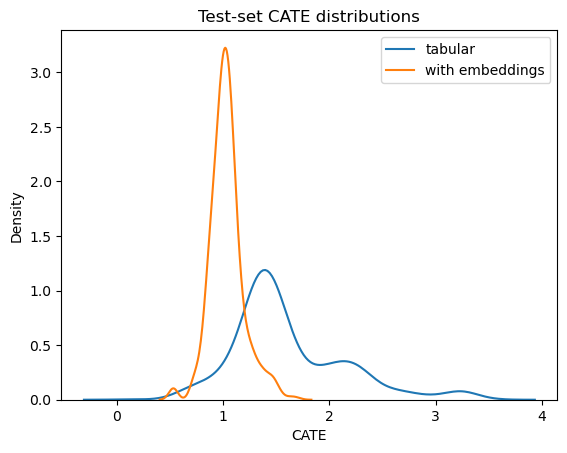

In [64]:
print("Tabular ATE (train/test):", ate_tab)
print("Image‐augmented ATE (train/test):", ate_img)

# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab.query("dataset=='test'")['CATE'], label='tabular')
sns.kdeplot(cate_img.query("dataset=='test'")['CATE'], label='with embeddings')
plt.legend(); plt.title("Test‐set CATE distributions")
plt.show()

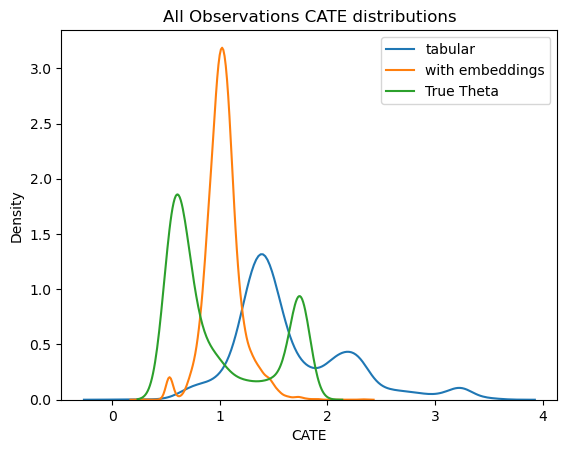

In [65]:
# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab['CATE'], label='tabular')
sns.kdeplot(cate_img['CATE'], label='with embeddings')
sns.kdeplot(cate_true['theta_mean'], label='True Theta')
plt.legend(); plt.title("All Observations CATE distributions")
# plt.xlim(0, 3)
plt.show()

In [86]:
df_actual = cate_true
df_estimated = cate_img
id_col = "scene_id"
actual_col = "theta_mean"
estimated_col = "CATE"

In [87]:

df = pd.merge(
    df_actual[[id_col, actual_col]],
    df_estimated[[id_col, estimated_col, "dataset"]],
    on=id_col,
    how="left",
)
df.head()

,scene_id,theta_mean,CATE,dataset
0,1,0.522187,1.248708,test
1,2,0.514523,0.911707,train
2,3,0.512433,0.777895,train
3,4,0.514598,0.879000,train
4,5,0.514765,0.690169,train


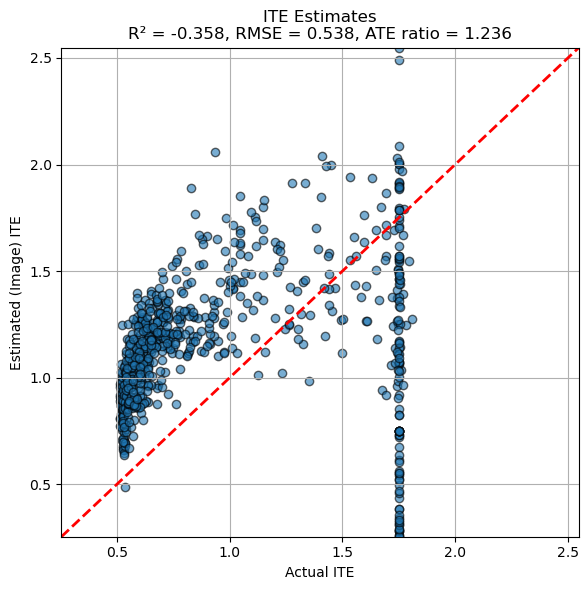

In [88]:
from sklearn.metrics import r2_score, mean_squared_error

df = df[df['dataset'] == "test"]

# 2) Extract arrays
y_true = df[actual_col].to_numpy()
y_pred = df[estimated_col].to_numpy()

# 3) Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
ate_true = y_true.mean()
ate_pred = y_pred.mean()
ate_ratio = ate_pred / ate_true if ate_true != 0 else np.nan

# 4) Scatter plot actual vs. estimated
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
lo = min(y_true.min(), y_pred.min())
hi = max(y_true.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.xlabel("Actual ITE")
plt.ylabel("Estimated (Image) ITE")
plt.title(
    f"ITE Estimates\nR² = {r2:.3f}, RMSE = {rmse:.3f}, ATE ratio = {ate_ratio:.3f}"
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
ate_true
ate_pred

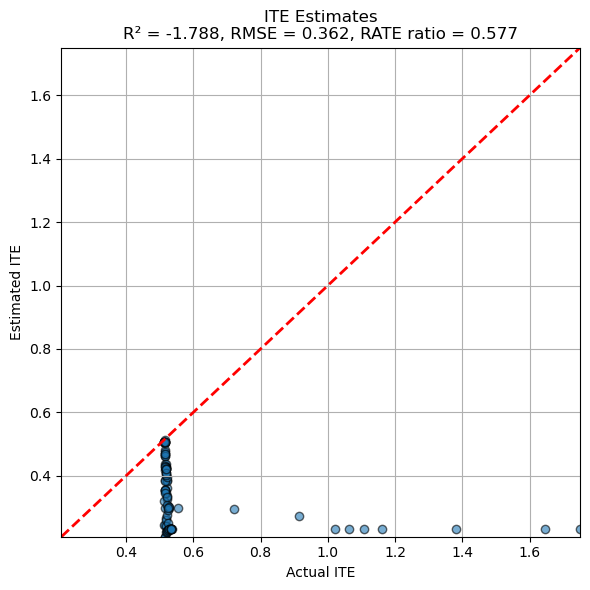

Saved histograms to:
  results/ite_plots/hist_actual_ite.png
  results/ite_plots/hist_estimated_ite.png
{'r2': -1.7875062990789927, 'rmse': 0.3615093002799662, 'rate_ratio': 0.5773558844927247}


In [18]:
# evaluating ITE with the actual data for tabular
metrics = evaluate_ite(
    cate_true,
    cate_tab,
    id_col="scene_id",
    actual_col="theta_mean",
    estimated_col="CATE",
    output_dir="results/ite_plots"
)
print(metrics)

In [4]:
# include image embeddings in the treatment
PCA_COLS = [f'PC{i+1}' for i in range(10)]

cate_img, ate_img, model_img = estimate_treatment_effect_with_embeddings(
    df,
    train_idx,
    test_idx,
    outcome_col=OUTCOME,
    treatment_col=PCA_COLS,
    covariate_cols=COVS
)

print("Tabular ATE (train/test):", ate_tab)
print("Image‐augmented ATE (train/test):", ate_img)

# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab.query("dataset=='test'")['CATE'], label='tabular')
sns.kdeplot(cate_img.query("dataset=='test'")['CATE_wet'], label='with embeddings')
plt.legend(); plt.title("Test‐set CATE distributions")
plt.show()

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


IndexError: invalid index to scalar variable.

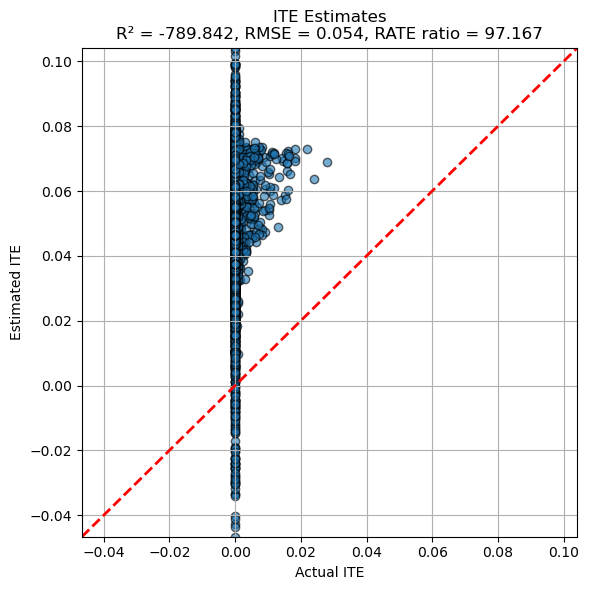

Saved histograms to:
  results/ite_plots/hist_actual_ite.png
  results/ite_plots/hist_estimated_ite.png
{'r2': -789.8421587103322, 'rmse': 0.05385770552831608, 'rate_ratio': 97.16689784155963}


In [7]:
# evaluating ITE with the actual data for tabular
metrics = evaluate_ite(
    cate_true,
    cate_tab,
    id_col="scene_id",
    actual_col="ite_mean",
    estimated_col="CATE",
    output_dir="results/ite_plots"
)
print(metrics)